In [1]:
import feature_extraction as fe

import numpy as np

import os
import random
import pickle
import warnings
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 3
random.seed(seed)
torch.manual_seed(seed)

warnings.filterwarnings('ignore')

In [2]:
def data_batcher(data, batch_size):
    random.shuffle(data)
    return [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

In [3]:
dataset = 'GTZAN'
new_spects = False


dataset_filename = f'../datasets/{dataset}.gui'
pickle_filename = f'./feats_spects-pickles/{dataset_filename.split("/")[-1][:-4]}_spects.pkl'

#spects, labels = fe.extract_spectrograms(dataset_filename)
if new_spects or not os.path.isfile(pickle_filename):
    spects, labels = fe.extract_spectrograms(dataset_filename)
    with open(pickle_filename, 'wb') as f:
        pickle.dump([spects, labels], f)
else:
    with open(pickle_filename, 'rb') as f:
        spects, labels = pickle.load(f)
    print(f'{spects.shape[0]} spectrograms extracted')

1000 spectrograms extracted


In [4]:
scaler = StandardScaler()
#scaled_feats = scaler.fit_transform(feats)

x_trainval, x_test, y_trainval, y_test = train_test_split(spects, labels, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.25)

train_data = [(x, y) for x, y in zip(x_train, y_train)]
val_data = [(x, y) for x, y in zip(x_val, y_val)]
test_data = [(x, y) for x, y in zip(x_test, y_test)]

print(len(train_data), "training samples")
print(len(val_data), "validation samples")
print(len(test_data), "test samples")

600 training samples
200 validation samples
200 test samples


In [5]:
class CNNClassifier(nn.Module):
    #def __init__(self, input_size, hidden_size, num_classes, embedding_size, num_layers):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()
        
        self.conv1d1 = nn.Conv1d(128, 64, 5, padding=2) 
        self.conv1d1_bn = nn.BatchNorm1d(64, momentum=0.9) 
        self.pool1 = torch.nn.MaxPool1d(kernel_size=4) 
        self.dropout1 = nn.Dropout(0.1)
        
        self.conv1d2 = nn.Conv1d(64, 32, 3, padding=1) 
        self.conv1d2_bn = nn.BatchNorm1d(32, momentum=0.9)
        self.pool2 = torch.nn.MaxPool1d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.1)
        
        self.conv1d3 = nn.Conv1d(32, 16, 3, padding=1) 
        self.conv1d3_bn = nn.BatchNorm1d(16, momentum=0.9)
        self.pool3 = torch.nn.MaxPool1d(kernel_size=2) 
        self.dropout3 = nn.Dropout(0.3)
        
        self.rnn = torch.nn.LSTM(16, 32, num_layers=2, batch_first=True, bidirectional=False)
        
        self.fc1 = nn.Linear(32, num_classes)
        
    
    def forward(self, x):
    
        out = x.permute(0,2,1)
        
        #Layer1
        out = F.relu(self.conv1d1_bn(self.conv1d1(out)))
        out = self.pool1(out)
        #out = self.dropout1(out)
        
        #Layer2
        out = F.relu(self.conv1d2_bn(self.conv1d2(out)))
        out = self.pool2(out)
        #out = self.dropout2(out)
        
        #Layer3
        out = F.relu(self.conv1d3_bn(self.conv1d3(out)))
        out = self.pool3(out)
        out = self.dropout3(out)
        
        # LSTM
        out = out.permute(0,2,1)
        out, (h_n, c_n) = self.rnn(out)
        out = h_n[-1,:,:]
        
        #FC
        out = self.fc1(out)
        
        return out

In [6]:
def train(log_interval, model, device, data_batches, optimizer, epoch):
    losses = []
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.train()
    
    total_loss = 0
    ncorrect = 0
    nsentences = 0
    ntokens = 0
    niterations = 0
    
    for i, batch in enumerate(data_batches):
        x, y = list(zip(*batch))
        
        X = [torch.from_numpy(d[0]) for d in batch]
        X_lengths = [x.numel() for x in X]
        ntokens += sum(X_lengths)
        X_lengths = torch.tensor(X_lengths, dtype=torch.long, device=device)
        
        
        # Move tensors to the configured device
        data = torch.from_numpy(np.array(x)).float().to(device)
        target = torch.from_numpy(np.array(y)).to(device)
        
        # clear all the gradients of the optimized tensors
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)#, X_lengths)
        loss = criterion(output, target)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (i+1) % log_interval == 0:
            print(f'Train Epoch: {epoch+1} [{(i+1)*len(data)}/{len_glob_data} ({str(int(100. * (i+1)*len(data) / len_glob_data)).zfill(2)}%)]\tLoss: {round(loss.item(),6)}')
    return np.array(losses).mean()

In [7]:
def validate(model, device, data_batches):
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = []
    correct = 0
    with torch.no_grad():  # we don't need gradient computation at all
        for i, batch in enumerate(data_batches):
            x, y = list(zip(*batch))
        
            data = torch.from_numpy(np.array(x)).float().to(device)
            target = torch.from_numpy(np.array(y)).to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            validation_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss = np.array(validation_loss).mean()
    accuracy = 100. * correct / len_glob_data

    print(f'\nValidation set: Average loss: {round(validation_loss, 4)}, Accuracy: {correct}/{len_glob_data} ({int(accuracy)}%)\n')
    
    return accuracy, validation_loss

In [8]:
def test(model, device, data_batches):
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.eval()  # let's put the model in evaluation mode

    correct = 0
    with torch.no_grad():  # we don't need gradient computation at all
        for i, batch in enumerate(data_batches):
            x, y = list(zip(*batch))
        
            data = torch.from_numpy(np.array(x)).float().to(device)
            target = torch.from_numpy(np.array(y)).to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len_glob_data

    print(f'Test set: Accuracy: {correct}/{len_glob_data} ({int(accuracy)}%)\n')
    
    return accuracy

In [9]:
num_classes = 10

train_batch_size = 100
valid_batch_size = 100

num_epochs = 500 # 150
learning_rate = 0.00005

In [10]:
train_data_batches = data_batcher(train_data, train_batch_size)
val_data_batches = data_batcher(val_data, valid_batch_size)

#model = CNNClassifier(input_size, hidden_size, num_classes, embedding_size, num_layers).to(device)
model = CNNClassifier(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []
accuracies = []

for epoch in range(num_epochs):
    
    train_loss = train(2, model, device, train_data_batches, optimizer, epoch)
    train_losses.append(train_loss)

    accuracy, valid_loss = validate(model, device, val_data_batches)
    valid_losses.append(valid_loss)
    accuracies.append(accuracy)

Train Epoch: 1 [200/600 (33%)]	Loss: 2.298831
Train Epoch: 1 [400/600 (66%)]	Loss: 2.297314
Train Epoch: 1 [600/600 (100%)]	Loss: 2.309762

Validation set: Average loss: 2.3076, Accuracy: 20/200 (10%)

Train Epoch: 2 [200/600 (33%)]	Loss: 2.297022
Train Epoch: 2 [400/600 (66%)]	Loss: 2.294719
Train Epoch: 2 [600/600 (100%)]	Loss: 2.308054

Validation set: Average loss: 2.3055, Accuracy: 20/200 (10%)

Train Epoch: 3 [200/600 (33%)]	Loss: 2.294497
Train Epoch: 3 [400/600 (66%)]	Loss: 2.293627
Train Epoch: 3 [600/600 (100%)]	Loss: 2.305911

Validation set: Average loss: 2.304, Accuracy: 20/200 (10%)

Train Epoch: 4 [200/600 (33%)]	Loss: 2.293452
Train Epoch: 4 [400/600 (66%)]	Loss: 2.292564
Train Epoch: 4 [600/600 (100%)]	Loss: 2.30487

Validation set: Average loss: 2.3027, Accuracy: 20/200 (10%)

Train Epoch: 5 [200/600 (33%)]	Loss: 2.291825
Train Epoch: 5 [400/600 (66%)]	Loss: 2.290962
Train Epoch: 5 [600/600 (100%)]	Loss: 2.303901

Validation set: Average loss: 2.3017, Accuracy: 20/200

Train Epoch: 41 [600/600 (100%)]	Loss: 2.209338

Validation set: Average loss: 2.2194, Accuracy: 58/200 (29%)

Train Epoch: 42 [200/600 (33%)]	Loss: 2.187267
Train Epoch: 42 [400/600 (66%)]	Loss: 2.194736
Train Epoch: 42 [600/600 (100%)]	Loss: 2.202033

Validation set: Average loss: 2.2163, Accuracy: 61/200 (30%)

Train Epoch: 43 [200/600 (33%)]	Loss: 2.181143
Train Epoch: 43 [400/600 (66%)]	Loss: 2.19455
Train Epoch: 43 [600/600 (100%)]	Loss: 2.196082

Validation set: Average loss: 2.2088, Accuracy: 60/200 (30%)

Train Epoch: 44 [200/600 (33%)]	Loss: 2.176834
Train Epoch: 44 [400/600 (66%)]	Loss: 2.184506
Train Epoch: 44 [600/600 (100%)]	Loss: 2.19267

Validation set: Average loss: 2.2031, Accuracy: 61/200 (30%)

Train Epoch: 45 [200/600 (33%)]	Loss: 2.172017
Train Epoch: 45 [400/600 (66%)]	Loss: 2.179406
Train Epoch: 45 [600/600 (100%)]	Loss: 2.182462

Validation set: Average loss: 2.1994, Accuracy: 61/200 (30%)

Train Epoch: 46 [200/600 (33%)]	Loss: 2.165332
Train Epoch: 46 [400/600


Validation set: Average loss: 2.1496, Accuracy: 39/200 (19%)

Train Epoch: 82 [200/600 (33%)]	Loss: 1.806212
Train Epoch: 82 [400/600 (66%)]	Loss: 1.842641
Train Epoch: 82 [600/600 (100%)]	Loss: 1.816534

Validation set: Average loss: 1.9561, Accuracy: 59/200 (29%)

Train Epoch: 83 [200/600 (33%)]	Loss: 1.807779
Train Epoch: 83 [400/600 (66%)]	Loss: 1.825555
Train Epoch: 83 [600/600 (100%)]	Loss: 1.832211

Validation set: Average loss: 2.2998, Accuracy: 33/200 (16%)

Train Epoch: 84 [200/600 (33%)]	Loss: 1.79146
Train Epoch: 84 [400/600 (66%)]	Loss: 1.81963
Train Epoch: 84 [600/600 (100%)]	Loss: 1.796389

Validation set: Average loss: 2.0747, Accuracy: 47/200 (23%)

Train Epoch: 85 [200/600 (33%)]	Loss: 1.791988
Train Epoch: 85 [400/600 (66%)]	Loss: 1.803892
Train Epoch: 85 [600/600 (100%)]	Loss: 1.791716

Validation set: Average loss: 1.9337, Accuracy: 59/200 (29%)

Train Epoch: 86 [200/600 (33%)]	Loss: 1.774058
Train Epoch: 86 [400/600 (66%)]	Loss: 1.800732
Train Epoch: 86 [600/600 

Train Epoch: 121 [600/600 (100%)]	Loss: 1.419006

Validation set: Average loss: 1.7976, Accuracy: 77/200 (38%)

Train Epoch: 122 [200/600 (33%)]	Loss: 1.390282
Train Epoch: 122 [400/600 (66%)]	Loss: 1.356215
Train Epoch: 122 [600/600 (100%)]	Loss: 1.404724

Validation set: Average loss: 1.7374, Accuracy: 73/200 (36%)

Train Epoch: 123 [200/600 (33%)]	Loss: 1.382371
Train Epoch: 123 [400/600 (66%)]	Loss: 1.344125
Train Epoch: 123 [600/600 (100%)]	Loss: 1.393985

Validation set: Average loss: 1.7407, Accuracy: 72/200 (36%)

Train Epoch: 124 [200/600 (33%)]	Loss: 1.381229
Train Epoch: 124 [400/600 (66%)]	Loss: 1.33799
Train Epoch: 124 [600/600 (100%)]	Loss: 1.388435

Validation set: Average loss: 1.8279, Accuracy: 72/200 (36%)

Train Epoch: 125 [200/600 (33%)]	Loss: 1.375716
Train Epoch: 125 [400/600 (66%)]	Loss: 1.321153
Train Epoch: 125 [600/600 (100%)]	Loss: 1.383937

Validation set: Average loss: 1.7194, Accuracy: 71/200 (35%)

Train Epoch: 126 [200/600 (33%)]	Loss: 1.360138
Train Epo

Train Epoch: 161 [400/600 (66%)]	Loss: 1.032064
Train Epoch: 161 [600/600 (100%)]	Loss: 1.113698

Validation set: Average loss: 1.54, Accuracy: 96/200 (48%)

Train Epoch: 162 [200/600 (33%)]	Loss: 1.096457
Train Epoch: 162 [400/600 (66%)]	Loss: 1.0337
Train Epoch: 162 [600/600 (100%)]	Loss: 1.109238

Validation set: Average loss: 1.6476, Accuracy: 86/200 (43%)

Train Epoch: 163 [200/600 (33%)]	Loss: 1.079704
Train Epoch: 163 [400/600 (66%)]	Loss: 1.035918
Train Epoch: 163 [600/600 (100%)]	Loss: 1.105713

Validation set: Average loss: 1.642, Accuracy: 89/200 (44%)

Train Epoch: 164 [200/600 (33%)]	Loss: 1.087435
Train Epoch: 164 [400/600 (66%)]	Loss: 1.024982
Train Epoch: 164 [600/600 (100%)]	Loss: 1.092084

Validation set: Average loss: 1.817, Accuracy: 76/200 (38%)

Train Epoch: 165 [200/600 (33%)]	Loss: 1.133527
Train Epoch: 165 [400/600 (66%)]	Loss: 1.008979
Train Epoch: 165 [600/600 (100%)]	Loss: 1.097917

Validation set: Average loss: 1.5786, Accuracy: 94/200 (47%)

Train Epoch: 1

Train Epoch: 201 [200/600 (33%)]	Loss: 0.972498
Train Epoch: 201 [400/600 (66%)]	Loss: 0.882828
Train Epoch: 201 [600/600 (100%)]	Loss: 0.969081

Validation set: Average loss: 1.5961, Accuracy: 90/200 (45%)

Train Epoch: 202 [200/600 (33%)]	Loss: 0.951428
Train Epoch: 202 [400/600 (66%)]	Loss: 0.880206
Train Epoch: 202 [600/600 (100%)]	Loss: 0.975914

Validation set: Average loss: 1.6912, Accuracy: 86/200 (43%)

Train Epoch: 203 [200/600 (33%)]	Loss: 0.948028
Train Epoch: 203 [400/600 (66%)]	Loss: 0.863381
Train Epoch: 203 [600/600 (100%)]	Loss: 0.97707

Validation set: Average loss: 1.6788, Accuracy: 81/200 (40%)

Train Epoch: 204 [200/600 (33%)]	Loss: 0.93828
Train Epoch: 204 [400/600 (66%)]	Loss: 0.880387
Train Epoch: 204 [600/600 (100%)]	Loss: 0.975756

Validation set: Average loss: 2.6139, Accuracy: 37/200 (18%)

Train Epoch: 205 [200/600 (33%)]	Loss: 0.987454
Train Epoch: 205 [400/600 (66%)]	Loss: 0.977896
Train Epoch: 205 [600/600 (100%)]	Loss: 0.979518

Validation set: Average 

Train Epoch: 240 [600/600 (100%)]	Loss: 0.861903

Validation set: Average loss: 1.5385, Accuracy: 96/200 (48%)

Train Epoch: 241 [200/600 (33%)]	Loss: 0.857859
Train Epoch: 241 [400/600 (66%)]	Loss: 0.793579
Train Epoch: 241 [600/600 (100%)]	Loss: 0.857309

Validation set: Average loss: 1.6046, Accuracy: 90/200 (45%)

Train Epoch: 242 [200/600 (33%)]	Loss: 0.886425
Train Epoch: 242 [400/600 (66%)]	Loss: 0.797548
Train Epoch: 242 [600/600 (100%)]	Loss: 0.857923

Validation set: Average loss: 1.6024, Accuracy: 92/200 (46%)

Train Epoch: 243 [200/600 (33%)]	Loss: 0.84152
Train Epoch: 243 [400/600 (66%)]	Loss: 0.803257
Train Epoch: 243 [600/600 (100%)]	Loss: 0.856369

Validation set: Average loss: 1.4867, Accuracy: 96/200 (48%)

Train Epoch: 244 [200/600 (33%)]	Loss: 0.84509
Train Epoch: 244 [400/600 (66%)]	Loss: 0.77904
Train Epoch: 244 [600/600 (100%)]	Loss: 0.85606

Validation set: Average loss: 1.4745, Accuracy: 92/200 (46%)

Train Epoch: 245 [200/600 (33%)]	Loss: 0.834076
Train Epoch:

Train Epoch: 280 [200/600 (33%)]	Loss: 0.780427
Train Epoch: 280 [400/600 (66%)]	Loss: 0.722487
Train Epoch: 280 [600/600 (100%)]	Loss: 0.773408

Validation set: Average loss: 1.5277, Accuracy: 94/200 (47%)

Train Epoch: 281 [200/600 (33%)]	Loss: 0.75495
Train Epoch: 281 [400/600 (66%)]	Loss: 0.699051
Train Epoch: 281 [600/600 (100%)]	Loss: 0.76726

Validation set: Average loss: 1.5218, Accuracy: 91/200 (45%)

Train Epoch: 282 [200/600 (33%)]	Loss: 0.777685
Train Epoch: 282 [400/600 (66%)]	Loss: 0.704395
Train Epoch: 282 [600/600 (100%)]	Loss: 0.769844

Validation set: Average loss: 1.5194, Accuracy: 94/200 (47%)

Train Epoch: 283 [200/600 (33%)]	Loss: 0.757722
Train Epoch: 283 [400/600 (66%)]	Loss: 0.699164
Train Epoch: 283 [600/600 (100%)]	Loss: 0.788389

Validation set: Average loss: 2.1365, Accuracy: 67/200 (33%)

Train Epoch: 284 [200/600 (33%)]	Loss: 0.806011
Train Epoch: 284 [400/600 (66%)]	Loss: 0.756818
Train Epoch: 284 [600/600 (100%)]	Loss: 0.823645

Validation set: Average 

Train Epoch: 320 [200/600 (33%)]	Loss: 0.780849
Train Epoch: 320 [400/600 (66%)]	Loss: 0.658206
Train Epoch: 320 [600/600 (100%)]	Loss: 0.768214

Validation set: Average loss: 1.4629, Accuracy: 95/200 (47%)

Train Epoch: 321 [200/600 (33%)]	Loss: 0.729614
Train Epoch: 321 [400/600 (66%)]	Loss: 0.659306
Train Epoch: 321 [600/600 (100%)]	Loss: 0.727147

Validation set: Average loss: 1.6995, Accuracy: 76/200 (38%)

Train Epoch: 322 [200/600 (33%)]	Loss: 0.717245
Train Epoch: 322 [400/600 (66%)]	Loss: 0.659666
Train Epoch: 322 [600/600 (100%)]	Loss: 0.731021

Validation set: Average loss: 1.5292, Accuracy: 87/200 (43%)

Train Epoch: 323 [200/600 (33%)]	Loss: 0.715121
Train Epoch: 323 [400/600 (66%)]	Loss: 0.648754
Train Epoch: 323 [600/600 (100%)]	Loss: 0.759963

Validation set: Average loss: 1.6121, Accuracy: 84/200 (42%)

Train Epoch: 324 [200/600 (33%)]	Loss: 0.690605
Train Epoch: 324 [400/600 (66%)]	Loss: 0.645238
Train Epoch: 324 [600/600 (100%)]	Loss: 0.692588

Validation set: Averag


Validation set: Average loss: 1.556, Accuracy: 90/200 (45%)

Train Epoch: 360 [200/600 (33%)]	Loss: 0.622545
Train Epoch: 360 [400/600 (66%)]	Loss: 0.572483
Train Epoch: 360 [600/600 (100%)]	Loss: 0.63113

Validation set: Average loss: 1.6012, Accuracy: 94/200 (47%)

Train Epoch: 361 [200/600 (33%)]	Loss: 0.614876
Train Epoch: 361 [400/600 (66%)]	Loss: 0.574882
Train Epoch: 361 [600/600 (100%)]	Loss: 0.606511

Validation set: Average loss: 1.5526, Accuracy: 90/200 (45%)

Train Epoch: 362 [200/600 (33%)]	Loss: 0.616467
Train Epoch: 362 [400/600 (66%)]	Loss: 0.55378
Train Epoch: 362 [600/600 (100%)]	Loss: 0.620828

Validation set: Average loss: 1.5518, Accuracy: 94/200 (47%)

Train Epoch: 363 [200/600 (33%)]	Loss: 0.61473
Train Epoch: 363 [400/600 (66%)]	Loss: 0.565468
Train Epoch: 363 [600/600 (100%)]	Loss: 0.618798

Validation set: Average loss: 1.6086, Accuracy: 88/200 (44%)

Train Epoch: 364 [200/600 (33%)]	Loss: 0.603714
Train Epoch: 364 [400/600 (66%)]	Loss: 0.553378
Train Epoch: 

Train Epoch: 399 [600/600 (100%)]	Loss: 0.54979

Validation set: Average loss: 1.5674, Accuracy: 93/200 (46%)

Train Epoch: 400 [200/600 (33%)]	Loss: 0.536628
Train Epoch: 400 [400/600 (66%)]	Loss: 0.491933
Train Epoch: 400 [600/600 (100%)]	Loss: 0.544851

Validation set: Average loss: 1.5675, Accuracy: 93/200 (46%)

Train Epoch: 401 [200/600 (33%)]	Loss: 0.551548
Train Epoch: 401 [400/600 (66%)]	Loss: 0.505469
Train Epoch: 401 [600/600 (100%)]	Loss: 0.546169

Validation set: Average loss: 1.6994, Accuracy: 85/200 (42%)

Train Epoch: 402 [200/600 (33%)]	Loss: 0.536481
Train Epoch: 402 [400/600 (66%)]	Loss: 0.512599
Train Epoch: 402 [600/600 (100%)]	Loss: 0.545005

Validation set: Average loss: 1.7592, Accuracy: 79/200 (39%)

Train Epoch: 403 [200/600 (33%)]	Loss: 0.534151
Train Epoch: 403 [400/600 (66%)]	Loss: 0.502403
Train Epoch: 403 [600/600 (100%)]	Loss: 0.545636

Validation set: Average loss: 1.7081, Accuracy: 84/200 (42%)

Train Epoch: 404 [200/600 (33%)]	Loss: 0.539875
Train Epo

Train Epoch: 439 [200/600 (33%)]	Loss: 0.48859
Train Epoch: 439 [400/600 (66%)]	Loss: 0.442984
Train Epoch: 439 [600/600 (100%)]	Loss: 0.512492

Validation set: Average loss: 1.7503, Accuracy: 81/200 (40%)

Train Epoch: 440 [200/600 (33%)]	Loss: 0.508666
Train Epoch: 440 [400/600 (66%)]	Loss: 0.46888
Train Epoch: 440 [600/600 (100%)]	Loss: 0.50016

Validation set: Average loss: 1.7914, Accuracy: 85/200 (42%)

Train Epoch: 441 [200/600 (33%)]	Loss: 0.478778
Train Epoch: 441 [400/600 (66%)]	Loss: 0.452373
Train Epoch: 441 [600/600 (100%)]	Loss: 0.537465

Validation set: Average loss: 1.7517, Accuracy: 88/200 (44%)

Train Epoch: 442 [200/600 (33%)]	Loss: 0.498598
Train Epoch: 442 [400/600 (66%)]	Loss: 0.446451
Train Epoch: 442 [600/600 (100%)]	Loss: 0.505643

Validation set: Average loss: 1.6119, Accuracy: 90/200 (45%)

Train Epoch: 443 [200/600 (33%)]	Loss: 0.482668
Train Epoch: 443 [400/600 (66%)]	Loss: 0.459958
Train Epoch: 443 [600/600 (100%)]	Loss: 0.501508

Validation set: Average l

Train Epoch: 479 [200/600 (33%)]	Loss: 0.459871
Train Epoch: 479 [400/600 (66%)]	Loss: 0.408749
Train Epoch: 479 [600/600 (100%)]	Loss: 0.466973

Validation set: Average loss: 1.6355, Accuracy: 89/200 (44%)

Train Epoch: 480 [200/600 (33%)]	Loss: 0.454083
Train Epoch: 480 [400/600 (66%)]	Loss: 0.413677
Train Epoch: 480 [600/600 (100%)]	Loss: 0.501908

Validation set: Average loss: 1.721, Accuracy: 86/200 (43%)

Train Epoch: 481 [200/600 (33%)]	Loss: 0.444578
Train Epoch: 481 [400/600 (66%)]	Loss: 0.413659
Train Epoch: 481 [600/600 (100%)]	Loss: 0.50198

Validation set: Average loss: 1.7693, Accuracy: 87/200 (43%)

Train Epoch: 482 [200/600 (33%)]	Loss: 0.450889
Train Epoch: 482 [400/600 (66%)]	Loss: 0.402142
Train Epoch: 482 [600/600 (100%)]	Loss: 0.467664

Validation set: Average loss: 1.6188, Accuracy: 92/200 (46%)

Train Epoch: 483 [200/600 (33%)]	Loss: 0.455237
Train Epoch: 483 [400/600 (66%)]	Loss: 0.407731
Train Epoch: 483 [600/600 (100%)]	Loss: 0.46781

Validation set: Average l

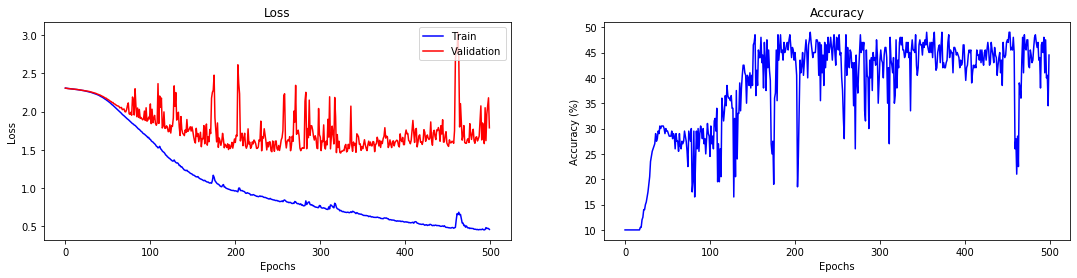

In [11]:
fig = plt.figure()
fig.subplots_adjust(right=2.5)

ax1 = fig.add_subplot(121)
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(train_losses, 'b-', label='Train')
ax1.plot(valid_losses, 'r-', label='Validation')
ax1.legend(loc='upper right')

ax1 = fig.add_subplot(122)
ax1.set_title('Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.plot(accuracies, 'b-')

plt.show()

In [12]:
test_data_batches = data_batcher(test_data, valid_batch_size)
accuracy = test(model, device, test_data_batches)

Test set: Accuracy: 107/200 (53%)

